# ЛР 3: Первинна обробка емпіричних даних з метрик ПЗ

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

csv_path = '/content/metrics.csv'

if csv_path and False:
    df = pd.read_csv(csv_path)
    x = df.iloc[:,0].values.astype(float)
else:
    rng = np.random.default_rng(7)
    x = rng.normal(500,120,size=60).clip(50,None).round(1)
    x[[5,31]] *= 2.2

N = len(x); x_mean = x.mean(); Sx2 = x.var(ddof=1); sigma_hat = np.sqrt(Sx2)
print(f"N={N}, x̄={x_mean:.2f}, Sx^2={Sx2:.2f}, sigmâ={sigma_hat:.2f}")


N=60, x̄=491.35, Sx^2=17401.08, sigmâ=131.91


### Гістограма + Normal PDF

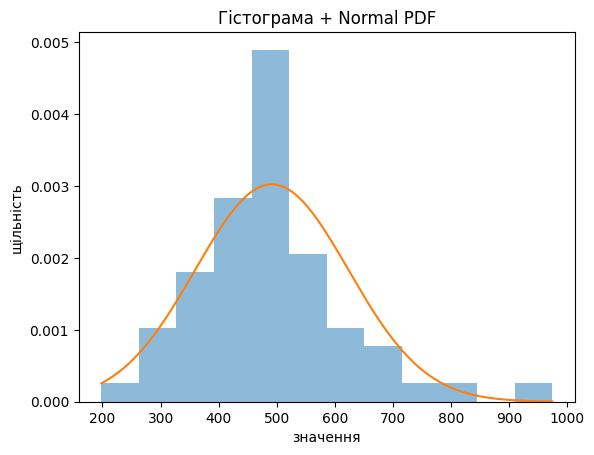

In [2]:

plt.figure()
count,bins,_ = plt.hist(x, bins=12, density=True, alpha=0.5)
mu, std = x.mean(), x.std(ddof=1)
xx = np.linspace(bins.min(), bins.max(), 200)
pdf = stats.norm.pdf(xx, mu, std)
plt.plot(xx, pdf)
plt.title('Гістограма + Normal PDF'); plt.xlabel('значення'); plt.ylabel('щільність')
plt.show()


### Тести нормальності (Shapiro, D’Agostino)

In [3]:

stat_sh, p_sh = stats.shapiro(x)
stat_da, p_da = stats.normaltest(x)
print(f"Shapiro p={p_sh:.4f}, D’Agostino p={p_da:.4f}")


Shapiro p=0.0141, D’Agostino p=0.0007


### Довірчі інтервали (95%) для x̄ та σ

In [4]:

alpha = 0.05
t = stats.t.ppf(1-alpha/2, df=N-1)
ci_mean = (x_mean - t*sigma_hat/np.sqrt(N), x_mean + t*sigma_hat/np.sqrt(N))

chi_lo = stats.chi2.ppf(alpha/2, df=N-1)
chi_hi = stats.chi2.ppf(1-alpha/2, df=N-1)
ci_sigma = (np.sqrt((N-1)*Sx2/chi_hi), np.sqrt((N-1)*Sx2/chi_lo))

print("CI x̄:", tuple(map(lambda v: round(v,2), ci_mean)))
print("CI σ :", tuple(map(lambda v: round(v,2), ci_sigma)))


CI x̄: (np.float64(457.27), np.float64(525.42))
CI σ : (np.float64(111.81), np.float64(160.89))


### Пошук викидів (Граббс)

In [5]:

def grubbs_test(x, alpha=0.05):
    x = np.asarray(x, float); N = len(x); mean = x.mean(); s = x.std(ddof=1)
    idx = np.argmax(np.abs(x-mean)); G = abs(x[idx]-mean)/s
    t = stats.t.ppf(1 - alpha/(2*N), N-2)
    Gcrit = ((N-1)/np.sqrt(N)) * np.sqrt(t**2 / (N-2 + t**2))
    return idx, G, Gcrit

idx, G, Gcrit = grubbs_test(x, 0.05)
print(f"G={G:.3f}, Gcrit={Gcrit:.3f} ->", "викид" if G>Gcrit else "ні")

x_clean = np.delete(x, idx) if G>Gcrit else x.copy()
print("Розмір після очищення:", len(x_clean))


G=3.658, Gcrit=3.200 -> викид
Розмір після очищення: 59


**Висновок:** отримано базові статистики, CI, перевірено нормальність, оброблено викиди. Готово до подальшого аналізу.